In [2]:
import dynamiqs as dq
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [108]:
#parameters
pi=jnp.pi
N=10 #Hilbert space dimension
n=2 #number Fock state
alpha=1 #coherent state amplitude
g2=1.0
k_b=10
e_d=-4

T      = 4.0      # total time
n_steps = 80      # number frame
tlist  = jnp.linspace(0, T, n_steps)

def cat_factory(n):
    cat_n = dq.coherent(N, alpha)
    for i in range(1,n):
        cat_n += dq.coherent(N, np.exp(1j*2*i*np.pi/n)*alpha)

    
    return cat_n / cat_n.norm()

def cat_dm_factory(n):
    cat_n = dq.coherent(N, alpha)
    for i in range(1,n):
        cat_n += dq.coherent(N, np.exp(1j*2*i*np.pi/n)*alpha)

    
    return (cat_n / cat_n.norm()).todm()


In [109]:
#operators and states
a=dq.destroy(N)
# I  = dq.eye(N)
# a_sys  = dq.tensor(a,  I)
# adag_sys = a_sys.dag()
# b_sys  = dq.tensor(I,  a)
# bdag_sys = b_sys.dag()

D = lambda alph: dq.expm(alph*a.dag() - alph.conjugate()*a)
P = dq.expm(1j*pi*a.dag()@a)

W_fromDP = lambda alph, rho: (2 / pi * dq.trace(D(alph) @ P @ D(alph).dag() @ rho)).item().real

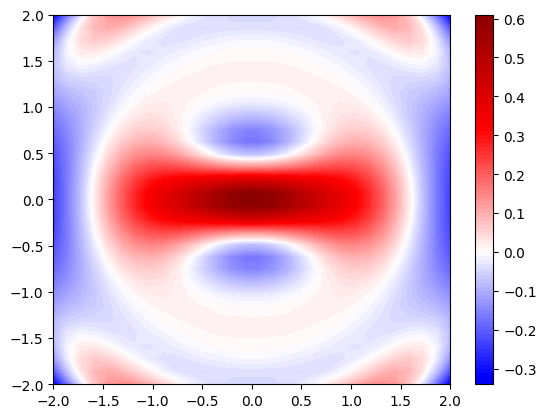

In [110]:
# some_state = dq.fock_dm(N, 1)
# some_state = dq.coherent_dm(N, 1) + dq.coherent_dm(N, -1)
some_state = cat_dm_factory(2)

nx, ny = 30, 30
xrange = (-2, 2)
yrange = (-2, 2)

xvals = np.linspace(xrange[0], xrange[1], nx)
yvals = np.linspace(yrange[0], yrange[1], ny)

wigner_values = np.zeros((nx,ny))

# xx, yy = np.meshgrid(xvals, yvals)

for xi, yi in np.ndindex((nx,ny)):
    xv, yv = xvals[xi], yvals[yi]
    wigner_values[xi, yi] = W_fromDP(xv+yv*1j, some_state)

plt.contourf(xvals, yvals, wigner_values.T, levels=100, cmap="seismic", vmin=-2/np.pi, vmax=2/np.pi)
plt.colorbar()


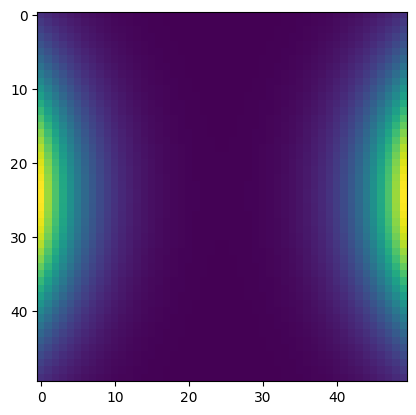

In [104]:
plt.imshow(wigner_values.T)

In [ ]:
alpha_k = [(1,1), (-1,1), (-1,-1), (1,-1)]

